In [1]:
import numpy as np
import pandas as pd
import skimage
print(skimage.__version__)

0.13.1


In [2]:
!ls

A0 - puppies                  __pycache__
A1 - annotation reading.ipynb annotation
B1 - sift - BOW.ipynb         annotation.tar
B2 - sift - BOW.ipynb         bowsift - sample.npz
B3 - sift - BOW.ipynb         features
C1 - Keras.ipynb              images.tar
C2 - Keras.ipynb              indexname.pickle
C3 - Keras.ipynb              lists
C4 - Keras.ipynb              lists.tar
D1 - Collaboratory.ipynb      pics
D1 - resnet50.ipynb           resnet50.hdf5
D2 - VGG16.ipynb              saved_model.hdf5
F1 - puppy recognyzer.ipynb   test
Images                        test_svg
Z1-picture_cropping.csv       testset.csv
Z2 - bowsift.npz              train
Z2 - dogs-breed-sample.csv    train_svg
Z2 - testset.npz              trainset.csv
Z2 - trainset.npz


# Misc info

In [3]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'
num_classes = 5


# Sub-features

In [0]:
#Create folders
import os
def folder_create(path):
    os.makedirs(os.path.join(path), exist_ok=True)

In [0]:
#Dowload files
from six.moves.urllib.request import urlretrieve
def downloadfile(filename, targetloc='.', url=url):
    dest_filename = os.path.join(targetloc, filename)
    filename, _ = urlretrieve(url + filename, dest_filename)
    print(dest_filename, 'created')
    return filename

In [0]:
#Extract files
import tarfile
import sys
def extract(filename, target, location = '.'):
    
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(target)
    tar.close()
    print(filename, 'created')

# dataset preparation

## Folder creation

In [0]:
# Folder creation
folder_create('lists')
folder_create('train')
folder_create('test')
folder_create('features')
folder_create('Annotation')

## downloading

In [8]:
#Datadownloading
downloadfile('lists.tar')
downloadfile('annotation.tar')
downloadfile('images.tar')
#downloadfile('train_data.mat', targetloc = 'features')
#downloadfile('test_data.mat', targetloc = 'features')

./lists.tar created
./annotation.tar created
./images.tar created


'./images.tar'

## Data preparation

In [9]:
#File extraction
extract('lists.tar', target='lists/')
extract('annotation.tar', target='.')
extract('images.tar', target='.')

lists.tar created
annotation.tar created
images.tar created


In [10]:
!ls

Annotation	datalab   Images      lists	 test
annotation.tar	features  images.tar  lists.tar  train


In [11]:
import scipy.io as sio
test_list = sio.loadmat('lists/test_list.mat')
train_list = sio.loadmat('lists/train_list.mat')
test_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [0]:
from bs4 import BeautifulSoup
from skimage.io import imread, imsave
from skimage import transform

def spreadfiles(listmat, serie=None, annotation='Annotation', images='Images'):
    counter = 0
    for filepath in listmat['file_list']:
        counter +=1
        if counter % 500 == 0:
            print(f'{counter} files done')
        cleanedfilepath = filepath[0][0]
        filename = os.path.split(cleanedfilepath)[-1].split('.')[0]
        foldername = os.path.split(cleanedfilepath)[0]
        details = {}
        with open(os.path.join(annotation, foldername, filename), 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'html.parser')
            dog = soup.find('object')
            details['xmin'] = int(dog.xmin.string)
            details['xmax'] = int(dog.xmax.string)
            details['ymin'] = int(dog.ymin.string)
            details['ymax'] = int(dog.ymax.string)
            #details['breed'] = dog.find_all('name')[0].string
        #print(os.path.join(images, foldername, f'{filename}.jpg'))
        image_data = imread(os.path.join(images, foldername, f'{filename}.jpg'))
        new_image_data = image_data[details['ymin']:details['ymax'],details['xmin']:details['xmax'],:]
        newpath = os.path.join(serie, foldername)
        #print(newpath)
        folder_create(newpath)
        try:
            imsave(os.path.join(newpath, f'{filename}.jpg'), new_image_data)
        except:
            print(f'problem with {filename} :-(')


In [13]:
%%time
spreadfiles(test_list, serie='test')



500 files done
1000 files done
1500 files done
2000 files done
2500 files done
3000 files done
3500 files done
4000 files done
4500 files done
5000 files done
5500 files done
6000 files done
6500 files done
7000 files done
7500 files done
8000 files done
8500 files done
CPU times: user 1min 54s, sys: 1.62 s, total: 1min 55s
Wall time: 1min 55s


In [14]:
%%time
spreadfiles(train_list, serie='train')

500 files done
1000 files done
1500 files done
2000 files done
2500 files done
3000 files done
3500 files done
4000 files done
4500 files done
5000 files done
5500 files done
6000 files done
6500 files done
7000 files done
7500 files done
8000 files done
8500 files done
9000 files done
9500 files done
10000 files done
10500 files done
11000 files done
11500 files done
12000 files done
CPU times: user 2min 40s, sys: 2.07 s, total: 2min 42s
Wall time: 2min 42s


# Resnet50

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import os 

/Users/cricket/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
print(keras.__version__)

2.1.4


In [6]:
image_size = 224
num_class = 5
batch_size = 32
num_channels = 3
train_data_dir = 'train'
validation_data_dir = 'test'

In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #shear_range=0.2,
                                   #channel_shift_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #rescale=1./255,
                                    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

Found 500 images belonging to 5 classes.
Found 389 images belonging to 5 classes.


## Baseline

In [7]:
baseline = ResNet50(include_top=True, weights='imagenet')
#baseline.summary()

In [8]:
pred = []
for img_path in validation_generator.filenames:
    img = image.load_img(os.path.join(validation_generator.directory, img_path), target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) #To add a dimension
    x = preprocess_input(x)

    preds = baseline.predict(x)
    readable = decode_predictions(preds, top=1)[0][0]
    code, breed, acc = decode_predictions(preds, top=1)[0][0]
    # decode the results into a list of tuples (class, description, probability)
    pred.append(validation_generator.class_indices.get(f'{code}-{breed}',-1))
    #print('Predicted:', readable)
pred[:10]

[0, 0, 0, 0, -1, -1, 0, 0, 0, 0]

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(validation_generator.classes, pred)

0.794344473007712

In [10]:
baseline.input_shape

(None, 224, 224, 3)

In [11]:
preds = baseline.predict_generator(validation_generator)

In [17]:
np.argmax(preds, axis=1).shape

(452,)

## pre-processing

In [62]:
from keras.applications.resnet50 import preprocess_input
#from keras.applications.vgg16 import preprocess_input

img = image.load_img('test/n02088364-beagle/n02088364_10354.jpg',
                     target_size=(image_size, image_size),
                    )
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) #To add a dimension
x = preprocess_input(x)

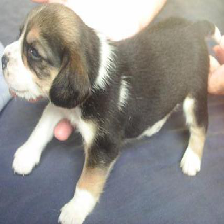

In [63]:
img

In [64]:
preprocpic = x.reshape([224,224,3])
print(preprocpic.max())
print(preprocpic.min())

151.061
-84.68


/Users/cricket/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


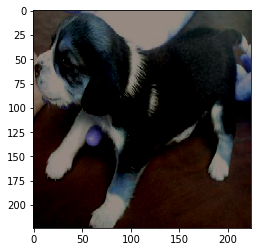

In [65]:


from skimage import img_as_ubyte
preprocpic = img_as_ubyte(preprocpic/255.)
plt.imshow(preprocpic)
plt.show()

In [55]:
preprocpic

array([[[ 70.061    ,  58.221    ,  49.32     ],
        [ 69.061    ,  57.221    ,  48.32     ],
        [ 69.061    ,  57.221    ,  48.32     ],
        ...,
        [ 48.060997 ,  53.221    ,  45.32     ],
        [ 47.060997 ,  52.221    ,  44.32     ],
        [ 46.060997 ,  51.221    ,  43.32     ]],

       [[ 69.061    ,  57.221    ,  48.32     ],
        [ 68.061    ,  56.221    ,  47.32     ],
        [ 68.061    ,  56.221    ,  47.32     ],
        ...,
        [ 51.060997 ,  56.221    ,  48.32     ],
        [ 48.060997 ,  53.221    ,  45.32     ],
        [ 47.060997 ,  52.221    ,  44.32     ]],

       [[ 68.061    ,  56.221    ,  47.32     ],
        [ 67.061    ,  55.221    ,  46.32     ],
        [ 67.061    ,  55.221    ,  46.32     ],
        ...,
        [ 53.060997 ,  58.221    ,  50.32     ],
        [ 49.060997 ,  54.221    ,  46.32     ],
        [ 47.060997 ,  52.221    ,  44.32     ]],

       ...,

       [[ -1.939003 , -35.779    , -50.68     ],
        [  

## Transfer learning - Bottlneck

In [12]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model

In [13]:
tr_model=ResNet50(include_top=False,
                  weights='imagenet',
                 input_shape = (224, 224, 3),
                 ) #
#tr_model.summary()

In [14]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale=1. / 255

In [17]:
# training label


train_generator = datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode=None,
                                                    batch_size=batch_size,
                                                    shuffle=False)

bottleneck_features_train = tr_model.predict_generator(train_generator)
train_labels = to_categorical(train_generator.classes , num_classes=num_class)


Found 500 images belonging to 5 classes.


In [18]:
validation_generator = datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode=None,
                                                        batch_size=batch_size,
                                                       shuffle=False)

bottleneck_features_validation = tr_model.predict_generator(validation_generator)
validation_labels = to_categorical( validation_generator.classes, num_classes=num_class)

Found 389 images belonging to 5 classes.


In [19]:
validation_generator.data_format

'channels_last'

In [36]:
indexlabel = {v:k[10:] for k,v in train_generator.class_indices.items()}
indexlabel

{0: 'beagle',
 1: 'boxer',
 2: 'Pomeranian',
 3: 'miniature_poodle',
 4: 'African_hunting_dog'}

In [21]:
import pickle
with open('indexname.pickle', 'wb') as handle:
    pickle.dump(indexname, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
tr_model.input_shape

(None, 224, 224, 3)

In [23]:
baseline.input_shape

(None, 224, 224, 3)

In [24]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(500, 1, 1, 2048)
(389, 1, 1, 2048)


In [25]:
print(train_labels.shape)
print(validation_labels.shape)

(500, 5)
(389, 5)


In [31]:

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

# Early stop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_model.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 10,245
Trainable params: 10,245
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(bottleneck_features_train, train_labels,
          epochs=30,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels),
                   callbacks=[checkpointer, early])

Train on 500 samples, validate on 389 samples
Epoch 1/30
500/500 [==============================] - 1s 2ms/step - loss: 0.8483 - acc: 0.7040 - val_loss: 0.1922 - val_acc: 0.9692

Epoch 00001: val_acc improved from -inf to 0.96915, saving model to saved_model.hdf5
Epoch 2/30
500/500 [==============================] - 0s 125us/step - loss: 0.0952 - acc: 0.9940 - val_loss: 0.0716 - val_acc: 0.9871

Epoch 00002: val_acc improved from 0.96915 to 0.98715, saving model to saved_model.hdf5
Epoch 3/30
500/500 [==============================] - 0s 119us/step - loss: 0.0384 - acc: 0.9980 - val_loss: 0.0464 - val_acc: 0.9923

Epoch 00003: val_acc improved from 0.98715 to 0.99229, saving model to saved_model.hdf5
Epoch 4/30
500/500 [==============================] - 0s 123us/step - loss: 0.0235 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9949

Epoch 00004: val_acc improved from 0.99229 to 0.99486, saving model to saved_model.hdf5
Epoch 5/30
500/500 [==============================] - 0s 119us/step

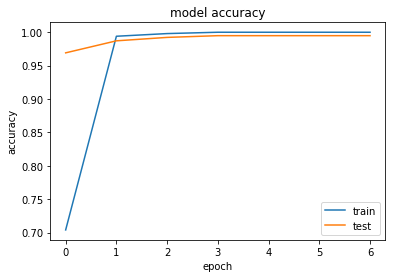

In [52]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

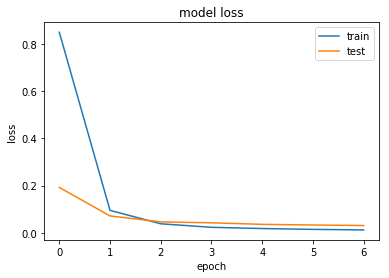

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Result analysis

In [47]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(true, preds, le=indexlabel, cmap=plt.cm.Blues, title='Confusion Matrix'):
    cm = confusion_matrix(true, preds)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    #classes = [le.inverse_transform(x) for x in range(cm.shape[0])]
    classes = [indexlabel.get(x,'?') for x in np.sort(np.unique(preds))]
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#plot_confusion_matrix(pipekpcolor)

In [38]:
#Confusion Matrix

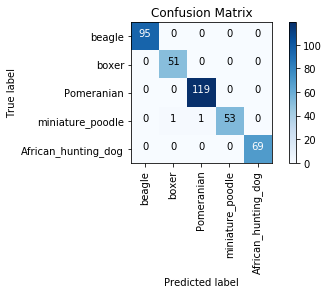

In [51]:
true=validation_generator.classes
preds = np.argmax(model.predict(bottleneck_features_validation), axis=1)
plot_confusion_matrix(true = true, preds=preds)

In [57]:
pred_probas = model.predict(bottleneck_features_validation)

In [58]:
#Misc value
maxval = [arr[index] for arr, index in zip(pred_probas, np.argsort(pred_probas, axis=1)[:,-1])]
predict = np.argsort(pred_probas, axis=1)[:,-1]
secondval = [arr[index] for arr, index in zip(pred_probas, np.argsort(pred_probas, axis=1)[:,-2])]

In [72]:
resultset = pd.DataFrame(data=pred_probas, columns = range(len(indexlabel)))
resultset = pd.concat([resultset, pd.DataFrame(data={'True': validation_generator.classes,
                                                     'maxval' : maxval,
                                                     'predict': predict,
                                                     'secondval': secondval,
                                                     #'breedname': X_test.breedname.tolist(),
                                                     'filepath': validation_generator.filenames})], axis=1)
resultset['correct'] = resultset['True'] == resultset['predict']
resultset['breedname'] = resultset['True'].apply(lambda x: indexlabel.get(x, -1))
resultset['diff'] = resultset['maxval'] - resultset['secondval']
resultset.head()

0         1         2         3         4  True  \
0  0.703606  0.111098  0.173317  0.011716  0.000262     0   
1  0.969769  0.022456  0.001646  0.000705  0.005424     0   
2  0.993408  0.005329  0.000688  0.000554  0.000020     0   
3  0.900560  0.048738  0.039783  0.009691  0.001229     0   
4  0.999422  0.000154  0.000027  0.000238  0.000160     0   

                               filepath    maxval  predict  secondval  \
0  n02088364-beagle/n02088364_10108.jpg  0.703606        0   0.173317   
1  n02088364-beagle/n02088364_10206.jpg  0.969769        0   0.022456   
2  n02088364-beagle/n02088364_10296.jpg  0.993408        0   0.005329   
3  n02088364-beagle/n02088364_10354.jpg  0.900560        0   0.048738   
4  n02088364-beagle/n02088364_10575.jpg  0.999422        0   0.000238   

   correct breedname      diff  
0     True    beagle  0.530289  
1     True    beagle  0.947312  
2     True    beagle  0.988079  
3     True    beagle  0.851822  
4     True    beagle  0.999184

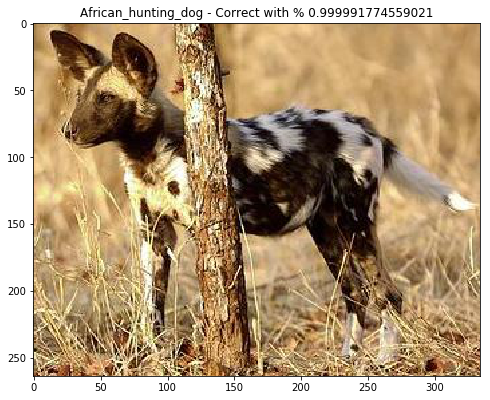

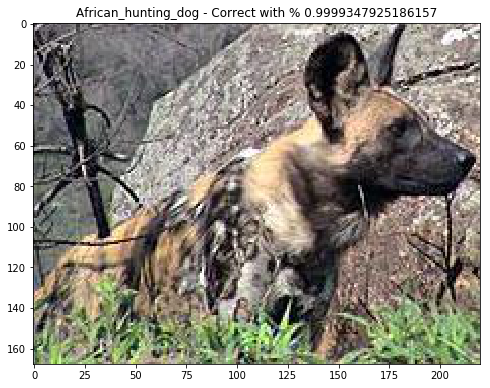

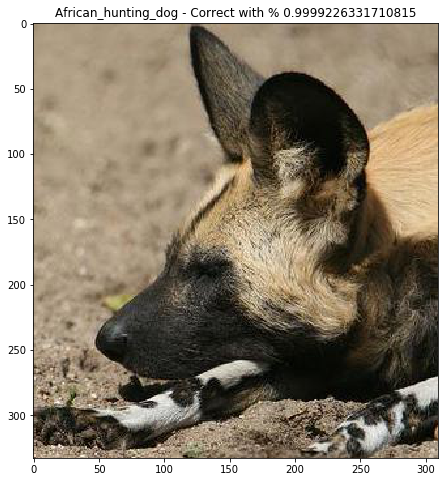

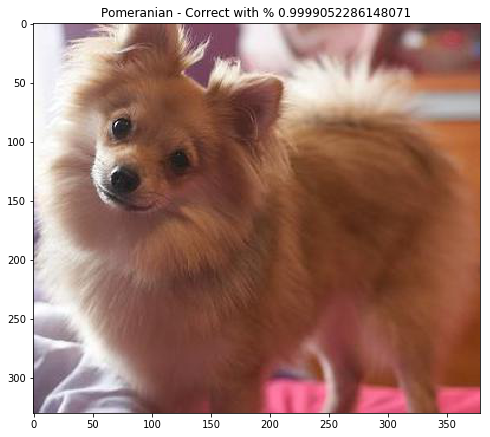

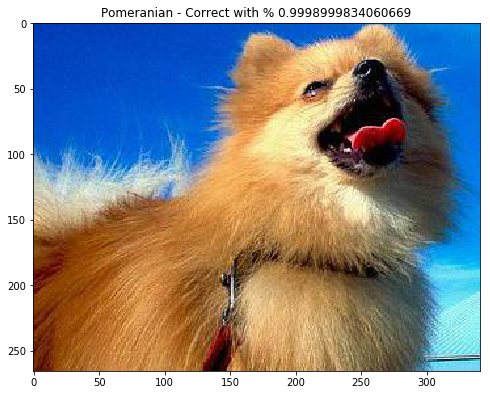

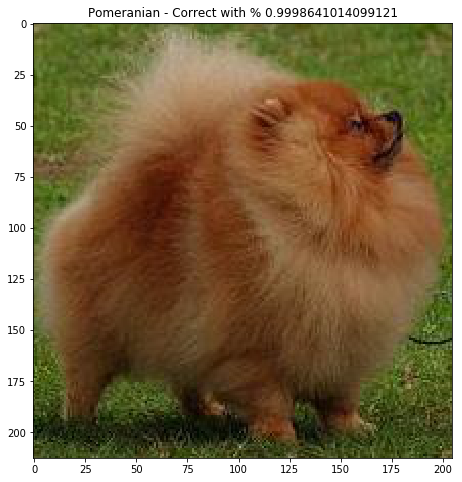

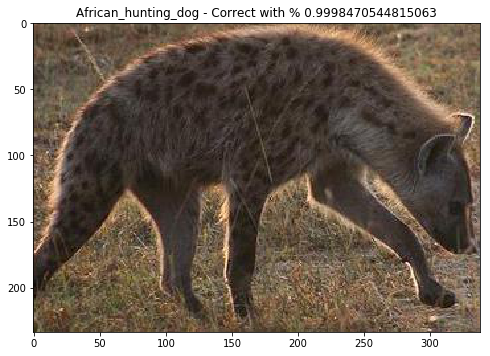

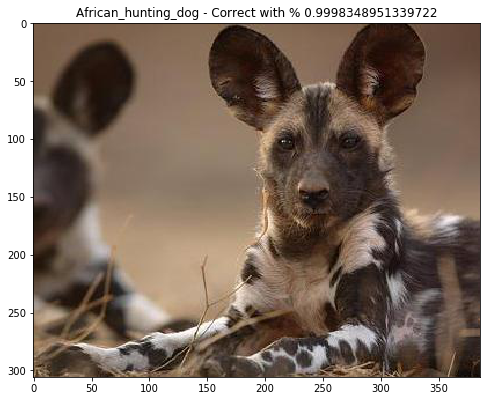

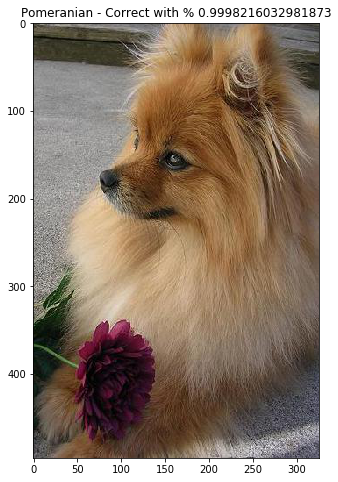

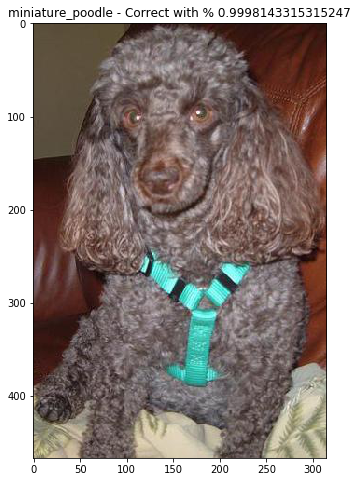

In [76]:
#Most right
from skimage.io import imread
%matplotlib inline
ds = resultset[resultset['correct']]
ds = ds.sort_values('maxval', ascending=False)
available = os.listdir('pics')

for index, line in ds[:10].iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Correct with % {}'.format(line.breedname, line.maxval))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))


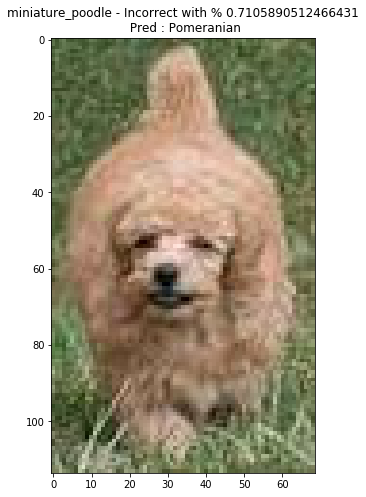

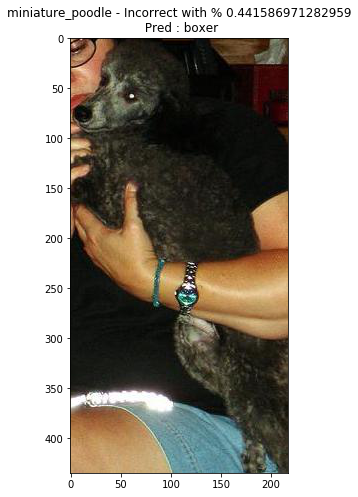

In [82]:
#Most wrong
%matplotlib inline
ds = resultset[np.logical_not(resultset['correct'])]
ds = ds.sort_values('maxval', ascending=False)
available = os.listdir('pics')
for index, line in ds.iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Incorrect with % {}\n Pred : {}'.format(line.breedname, line.maxval, indexlabel.get(line.predict)))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))

In [84]:
ds

0         1             2         3             4  True  \
288  1.524039e-02  0.078970  5.147942e-02  0.479700  3.746098e-01     3   
11   5.571927e-01  0.195123  4.859172e-03  0.239882  2.943007e-03     0   
335  1.595940e-03  0.174517  5.598586e-02  0.109578  6.583236e-01     4   
0    7.036062e-01  0.111098  1.733175e-01  0.011716  2.624173e-04     0   
128  1.732715e-01  0.724887  7.651494e-03  0.001505  9.268495e-02     1   
32   7.805263e-01  0.209591  3.457261e-03  0.005534  8.917805e-04     0   
63   8.014818e-01  0.163376  2.695014e-03  0.032162  2.854008e-04     0   
81   8.410673e-01  0.152880  1.407902e-04  0.004984  9.274044e-04     0   
172  9.634794e-03  0.017080  8.417798e-01  0.128987  2.518876e-03     2   
270  7.622862e-03  0.002619  1.279200e-01  0.861093  7.454599e-04     3   
298  1.015280e-01  0.008882  4.067054e-02  0.842513  6.406025e-03     3   
259  1.054013e-01  0.010601  8.573697e-01  0.024491  2.137528e-03     2   
299  1.196415e-02  0.071556  2.303234e-02  0.847368  4.607968e-02     3   
193  3.813296e-03  0.004626  8.744816e-01  0.018768  9.831090e-02     2   
242  9.524485e-02  0.024144  8.752450e-01  0.001779  3.586771e-03     2   
192  9.287580e-03  0.000908  8.966061e-01  0.092343  8.554133e-04     2   
279  1.019672e-02  0.075779  8.947349e-03  0.891325  1.375196e-02     3   
17   9.067735e-01  0.090409  1.227270e-03  0.001456  1.338583e-04     0   
302  1.672411e-04  0.000622  8.219972e-02  0.916996  1.514538e-05     3   
119  7.418136e-02  0.925315  3.799612e-04  0.000091  3.239127e-05     1   
3    9.005603e-01  0.048738  3.978264e-02  0.009691  1.228796e-03     0   
316  3.359792e-03  0.003200  6.554933e-02  0.925038  2.853150e-03     3   
58   9.225267e-01  0.055765  1.335827e-02  0.002547  5.803578e-03     0   
27   9.194872e-01  0.024184  5.867332e-03  0.050188  2.728401e-04     0   
54   9.264161e-01  0.056316  9.080030e-03  0.005328  2.859921e-03     0   
39   9.326305e-01  0.005994  9.491290e-04  0.059032  1.394226e-03     0   
83   9.358728e-01  0.061901  1.151662e-03  0.000194  8.806711e-04     0   
115  6.028091e-02  0.936468  5.970736e-04  0.002216  4.387753e-04     1   
361  1.620600e-04  0.002927  5.575476e-04  0.060013  9.363404e-01     4   
111  5.837791e-02  0.936702  1.382498e-03  0.001417  2.120678e-03     1   
..            ...       ...           ...       ...           ...   ...   
121  3.165969e-04  0.999564  2.765586e-05  0.000088  3.930392e-06     1   
214  2.501082e-04  0.000048  9.995064e-01  0.000008  1.875270e-04     2   
268  3.005642e-05  0.000280  6.893749e-05  0.999544  7.758986e-05     3   
15   9.996217e-01  0.000347  4.402506e-06  0.000020  6.762265e-06     0   
185  8.865345e-06  0.000004  9.996312e-01  0.000351  5.124657e-06     2   
149  2.911165e-05  0.000052  9.996055e-01  0.000308  6.310022e-06     2   
218  1.097988e-05  0.000022  9.996365e-01  0.000316  1.446825e-05     2   
304  1.190859e-04  0.000265  1.678250e-05  0.999593  5.934921e-06     3   
148  1.656285e-04  0.000077  9.995591e-01  0.000181  1.757518e-05     2   
155  1.437227e-04  0.000061  9.995874e-01  0.000186  2.228012e-05     2   
294  1.247495e-05  0.000224  1.113987e-04  0.999648  3.653579e-06     3   
110  3.632751e-05  0.999668  1.949845e-05  0.000213  6.425160e-05     1   
173  4.573219e-05  0.000053  9.996854e-01  0.000206  1.049123e-05     2   
256  6.208564e-05  0.000040  9.997204e-01  0.000173  4.360885e-06     2   
372  1.715216e-05  0.000160  1.330639e-05  0.000039  9.997696e-01     4   
170  7.048056e-05  0.000052  9.997380e-01  0.000126  1.399004e-05     2   
262  6.433043e-05  0.000028  9.997292e-01  0.000114  6.401922e-05     2   
261  5.507197e-05  0.000087  9.997233e-01  0.000079  5.539798e-05     2   
269  1.653503e-05  0.000164  4.594056e-06  0.999814  7.131135e-07     3   
274  1.055426e-04  0.000106  3.006868e-05  0.999757  2.008652e-06     3   
386  3.151743e-05  0.000053  5.761818e-05  0.000099  9.997593e-01     4   
180  1.786744e-05  0.000011  9.998216e-01

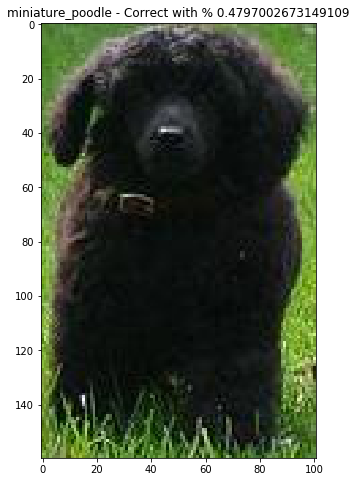

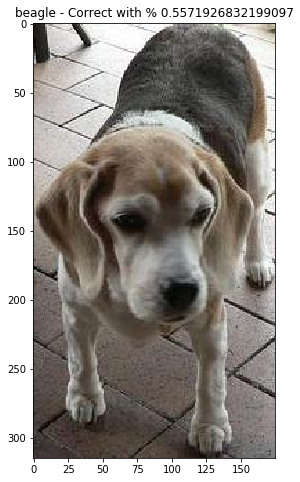

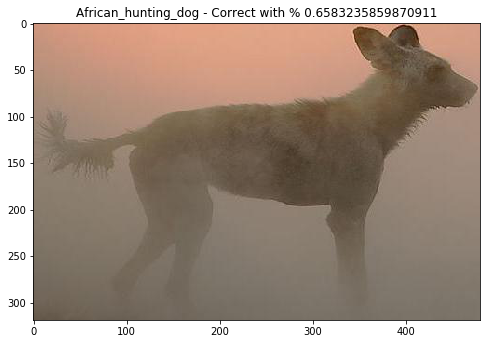

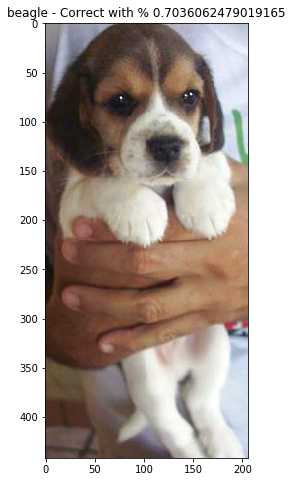

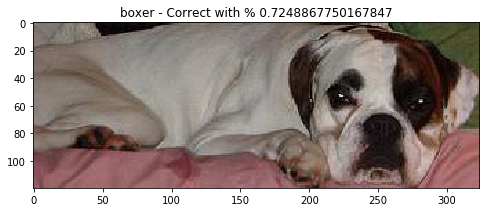

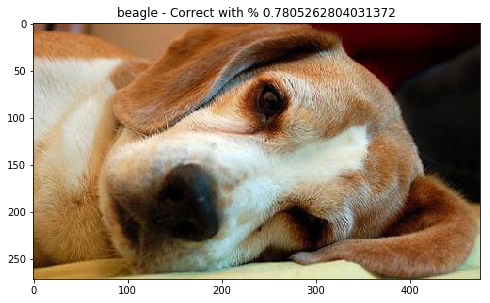

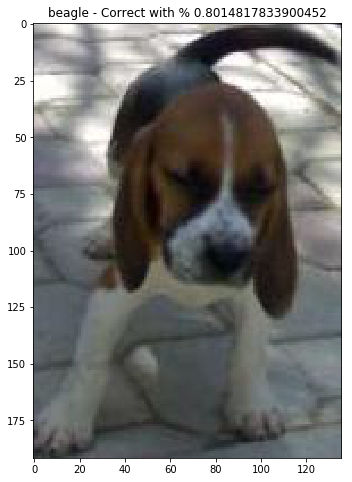

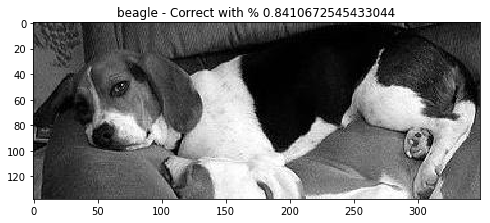

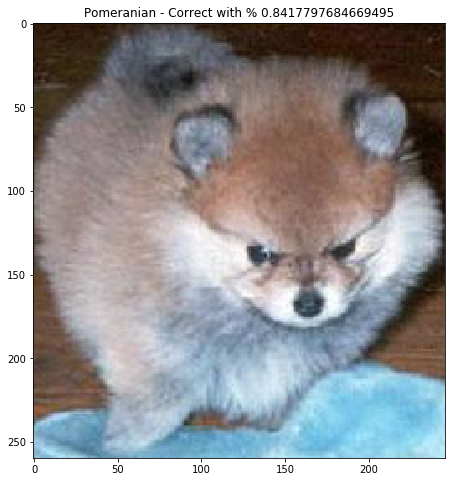

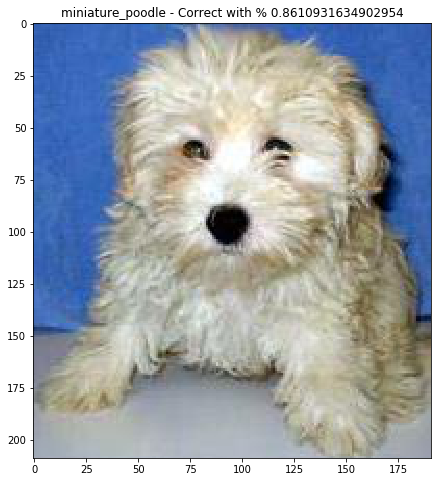

In [83]:
#Most uncertain TRUE
%matplotlib inline
ds = resultset[resultset['correct']]
ds = ds.sort_values('diff', ascending=True)
available = os.listdir('pics')
for index, line in ds[:10].iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Correct with % {}'.format(line.breedname, line.maxval))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))